In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import scipy

In [3]:
def get_data_classes(df, acros, ratio=0.5, verbose=False, predict="class", judgement_weighted=True, mapping="clip"):
    if verbose:
        print(f"df original shape {df.shape}")
        
    n_rows_old = len(df)
    
    # Map negative judgements to opposing judgement
    # i.e. YTA<->NTA, ESH<->NAH
    if judgement_weighted:
        df = map_negative_values(df, acros,mapping=mapping)
    
    if predict=="class": 
        print("CLASS")  
        # We only look at YTA and NTA
        df["YTA_ratio"] = df[acros["yta"]]/(df[acros["info"]]+ df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])

        # drop all rows where the majority is not YTA or NTA
        df = df.loc[((df[acros["yta"]] > df[acros["info"]]) & (df[acros["yta"]] > df[acros["nah"]]) & (df[acros["yta"]] > df[acros["esh"]])) | ((df[acros["nta"]] > df[acros["info"]]) & (df[acros["nta"]] > df[acros["nah"]]) & (df["reactions_weighted_NTA"] > df[acros["esh"]]))]
        if verbose:
            print(f"Drop all rows where majority is not YTA or NTA {df.shape}")

        #drop all rows that are not "extreme" enough
        df = df.loc[(1-ratio<=df["YTA_ratio"]) | (df["YTA_ratio"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")

        #specifc classes & drop unnecesarry
        df["Y"] = np.where(df[acros["yta"]] > df[acros["nta"]], 1,  0) # YTA = Class 1, NTA = class 0
        if verbose:
            print(df.shape)
            
    elif predict == "ratio":
        print("RATIO")
        # Y = asshole ratio(AHR) = (YTA+ESH)/(YTA+ESH+NTA+NAH)
        
        for acr in acros:
            min = df[acros[acr]].min()
            if min < 0:
                print(f"{acr} min = {min}")
                
        df["Y"] = (df[acros["yta"]]+df[acros["esh"]])/(df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])
        
        #drop NAs & infty
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna(subset=["Y"])
        if verbose:
           print(f"Removed {n_rows_old-len(df)} rows b.c. no votes. Now {df.shape}")
        n_rows_old = len(df)
        df = df.loc[(1-ratio<=df["Y"]) | (df["Y"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")
        
    y = df[["post_id", "Y"]]
    return y
     
        
    ###left as is
    # get list of all columns that contain uppercase vote acronym
    vote_acroynms = list(filter(lambda x: any([acr.upper() in x for acr in list(acros.keys())]), list(df.columns)))  
    df = df.drop(columns=vote_acroynms)
    
    cols_to_drop =  ["post_text", "post_id", "post_created_utc"] 
    for col in cols_to_drop:
        if col in list(df.columns):
            df = df.drop(columns=[col])
        
    #print(df.info(memory_usage="deep"))

    # Removing top 4 most important features leads to 0.66 f1
    #df = df.drop(columns=["speaker_account_comment_karma", "post_num_comments", "speaker_account_link_karma", "speaker_account_age"])
    if verbose:
        print(df.shape)
    
    X = df.drop(columns=["Y"])
    y = df["Y"].to_numpy()

    feat_name_lst = list(X.columns)

    # scaling
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, y, feat_name_lst  

def map_negative_values(df, acros, mapping="clip"):
    
    if mapping == "opposite" or mapping =="map":
        print("Map = opposite")    
        for k in acros.keys():
            acr = acros[k]
            #print(f"{acr} pos amount {len(df.loc[df[acr] > 0])}")
            #print(f"{acr} neg amount {len(df.loc[df[acr] < 0])}")
            
            
            if k == "info":
                continue
            
            # create temporary columns containing zeros and only negative votes for each vote type (except info)        
            df[acr+"_neg_vals"] = 0
            df.loc[df[acr] < 0, acr+"_neg_vals"] = df[acr]*-1
            df.loc[df[acr] < 0, acr] = 0
            
        for k in acros.keys():
            if k == "info":
                continue
            acr = acros[k]
            #set negative values to 0 & add opposite judgement vote 
            df[acr] = df[acr] + df[opposite_jdgmt(acr)]
           
    elif mapping =="clip":
        print("Map = clip")    
        for k in acros.keys():
            acr = acros[k]
            df.loc[df[acr]<0,acr]=0
        
            
    # finally set all negative info votes to 0
    #df[df[acros["info"]] < 0] = 0
    
    #print("info sum", df[acros["info"]].min())
    
    return df

def opposite_jdgmt(judg):
    
    if "NTA" in judg  :
        rtn =  judg.replace("NTA","YTA")
    elif "NAH" in judg:
        rtn =  judg.replace("NAH","ESH")
    elif "YTA" in judg:
        rtn =  judg.replace("YTA","NTA")
    elif "ESH" in judg:
        rtn =  judg.replace("ESH","NAH")
    elif "INFO" in judg:
        rtn = judg
    
    return rtn+"_neg_vals"

def load_wo_cols(path, remove_cols=[],verbose=False):
    cols_to_remove = ["post_text", "Unnamed: 0", "Unnamed: 1", "Unnamed: 2", "Unnamed: 0.1", 
                      "Unnamed: 0.1.1", "liwc_post_id", "foundations_post_id", 
                      "foundations_title_post_id", "liwc_title_post_id", "post_created_utc"]+remove_cols
    removed = []
    df = pd.read_csv(path, nrows=10)
    cols_to_read = list(df.columns)
    
    if verbose:
        print(cols_to_read)
    for col in cols_to_remove:
        if col in cols_to_read:
            cols_to_read.remove(col)
            removed.append(col)
    
    print(f"Removed {removed} from {path.split('/')[-1]}")        
    df = pd.read_csv(path, usecols=cols_to_read)
    return df

In [4]:
#df1 = load_wo_cols("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_scores_no_utc.csv")
#df2 = load_wo_cols("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_scores_no_utc.csv")
df1 = load_wo_cols("../datasets/prepend_complete.csv")
df2 = load_wo_cols("../datasets/prepend_complete.csv")

keys = ["info", "yta", "nah", "esh", "nta"]
weight = "weighted_" if True else ""
values = ["reactions_"+weight+k.upper() for k in keys]
acros = dict(zip(keys, values))
    
y_clip = get_data_classes(df1, acros, predict="ratio", mapping="clip")
y_map = get_data_classes(df2, acros, predict="ratio", mapping="opposite")

Removed ['Unnamed: 0', 'Unnamed: 0.1.1', 'liwc_post_id', 'foundations_post_id'] from prepend_complete.csv


/tmp/ipykernel_6286/4036007561.py:3: DtypeWarning: Columns (241,242) have mixed types.Specify dtype option on import or set low_memory=False.
  df1 = load_wo_cols("../datasets/prepend_complete.csv")


Removed ['Unnamed: 0', 'Unnamed: 0.1.1', 'liwc_post_id', 'foundations_post_id'] from prepend_complete.csv


/tmp/ipykernel_6286/4036007561.py:4: DtypeWarning: Columns (241,242) have mixed types.Specify dtype option on import or set low_memory=False.
  df2 = load_wo_cols("../datasets/prepend_complete.csv")


Map = clip
RATIO
Map = opposite
RATIO
info min = -294


In [5]:
y_merged =  y_clip.merge(y_map, left_on="post_id", right_on="post_id", validate="1:1",suffixes=('_clip', '_map'))
print(y_merged.columns)

Index(['post_id', 'Y_clip', 'Y_map'], dtype='object')


Pearson R (0.9985971406468636, 0.0)


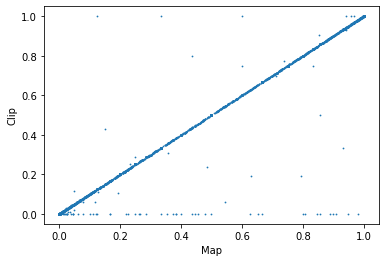

In [10]:
import matplotlib.pyplot as plt
clp = y_merged["Y_clip"]
mp = y_merged["Y_map"]

plt.scatter(mp, clp, s=0.6)
plt.ylabel("Clip")
plt.xlabel("Map")
print(f"Pearson R {scipy.stats.pearsonr(mp,clp)}")

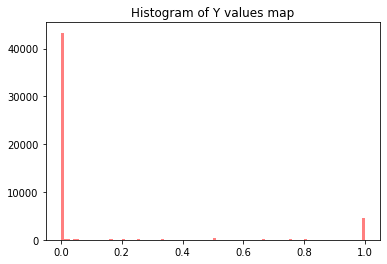

In [11]:
n, bins, patches = plt.hist(mp, 100, facecolor='red', alpha=0.5)
plt.title("Histogram of Y values map")
plt.show()

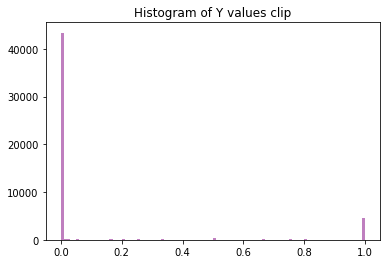

In [12]:
n, bins, patches = plt.hist(clp, 100, facecolor='purple', alpha=0.5)
plt.title("Histogram of Y values clip")
plt.show()

In [9]:
print(y_merged.head(100).to_string())

   post_id    Y_clip     Y_map
0   cpk7ui  0.000000  0.000000
1   cpk7vf  0.583333  0.583333
2   cpk8j1  0.000000  0.000000
3   cpk9i3  0.000000  0.000000
4   cpkaaq  0.000000  0.000000
5   cpkb40  0.000000  0.000000
6   cpkcqf  0.000000  0.000000
7   cpkd35  0.000000  0.000000
8   cpke5g  0.000000  0.000000
9   cpkfnt  0.000000  0.000000
10  cpkgbt  0.000000  0.000000
11  cpkgf9  0.000000  0.000000
12  cpkjai  0.000000  0.000000
13  cpkjld  0.000000  0.000000
14  cpkkcq  0.000000  0.000000
15  cpklda  0.636364  0.636364
16  cpkmgs  0.000000  0.000000
17  cpkmrt  0.000000  0.000000
18  cpko86  0.000000  0.000000
19  cpkp51  0.000000  0.000000
20  cpkpl9  0.000000  0.000000
21  cpkq7y  0.000000  0.000000
22  cpkr7c  0.000000  0.000000
23  cpks5g  0.000000  0.000000
24  cpktvk  0.000000  0.000000
25  cpku07  0.000000  0.000000
26  cpkvr7  0.000000  0.000000
27  cpkwwb  0.000000  0.000000
28  cpkyd2  0.500000  0.500000
29  cpkzbc  0.000000  0.000000
30  cpl234  0.000000  0.000000
31  cpl2